# なまり評価モデルの探索的データ分析(EDA)

Common Voiceは、音声認識システム（ASR）のトレーニングやテストを目的とした、Mozillaが提供する公開音声データセットです。ユーザーが朗読した音声と、それに対応するテキストを収録されています。

このデータセットは英語のスピーチを収集したものですが、1部話者のアクセントが記録されており、なまり評価モデルの精度分析に適していると考えたため採用しました。

EDAは、様々な分析を行い、データビジュアライゼーションを行うことで、知りたい情報を分析するのはもちろん、今まで気づかなかった特徴を探索することも目的としているため、直接本研究に関わらないような分析も行っています。

In [1]:
model_path = "openai/whisper-base"

accent_to_json = {
    'malaysia': "Malay (macrolanguage)",
    'newzealand': "English",
    'canada': "English",
    'england': "English",
    'ireland': "English",
    'us': "English",
    'african': "Afrikaans",
    'hongkong': "Chinese",
    'bermuda': "English",
    'indian': "Hindi",
    'australia': "English",
    'scotland': "English",
    'wales': "Welsh"
}
# exclusions ["singapore", "ireland", "philippines", "southatlandtic"]

In [2]:
!nvidia-smi

Thu Dec 19 13:57:32 2024       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 560.35.03              Driver Version: 560.35.03      CUDA Version: 12.6     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  Tesla P100-PCIE-16GB           Off |   00000000:00:04.0 Off |                    0 |
| N/A   37C    P0             27W /  250W |       0MiB /  16384MiB |      0%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

In [3]:
!pip install iso639-lang

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 325.0/325.0 kB 8.0 MB/s eta 0:00:00


In [4]:
from typing import Dict, List, Tuple

import sys
import re
import torch
import torchaudio
from iso639 import Lang
from torchaudio.transforms import Resample
from transformers import (
    WhisperForConditionalGeneration,
    WhisperProcessor,
    WhisperTokenizer,
)


class AudioProcessor:
    def __init__(self, model_path: str = "openai/whisper-tiny"):
        self.model = WhisperForConditionalGeneration.from_pretrained(model_path).to("cuda")
        self.tokenizer = WhisperTokenizer.from_pretrained(model_path)
        self.processor = WhisperProcessor.from_pretrained(model_path)
        print(f"Audio backends: {torchaudio.list_audio_backends()}")

    def load_audio(
        self, audio_file_path: str, max_duration: int = 60
    ) -> Tuple[torch.Tensor, int]:
        waveform, sample_rate = torchaudio.load(
            uri=audio_file_path, backend="soundfile"
        )
        max_samples = max_duration * sample_rate
        waveform = waveform[:, :max_samples]
        if sample_rate != 16000:
            waveform = Resample(orig_freq=sample_rate, new_freq=16000)(waveform)
            sample_rate = 16000
        return waveform, sample_rate

    def audio_preprocess(
        self, waveform: torch.Tensor, sample_rate: int
    ) -> torch.Tensor:
        return self.processor(
            waveform.squeeze().numpy(), sampling_rate=sample_rate, return_tensors="pt"
        ).input_features

    def get_lang_tokens(self) -> List[str]:
        return [t for t in self.tokenizer.additional_special_tokens if len(t) == 6]

    def get_model_logits(self, input_features: torch.Tensor) -> torch.Tensor:
        TRANSCRIBE_TOKEN_ID = 50258
        decoder_input_ids = torch.full(
            (input_features.shape[0], 1), TRANSCRIBE_TOKEN_ID, dtype=torch.long
        ).to("cuda")
        return self.model(input_features, decoder_input_ids=decoder_input_ids).logits

    def get_tokens_probabilities(
        self, logits: torch.Tensor, token_ids: List[int]
    ) -> Tuple[torch.Tensor, torch.Tensor]:
        logits = logits.clone()
        mask = torch.ones_like(logits, dtype=torch.bool)
        mask[:, :, token_ids] = False
        logits[mask] = -float("inf")
        return logits, logits.softmax(dim=-1).cpu()

    def get_sorted_results(
        self, logits: torch.Tensor, tokens: List[str]
    ) -> Dict[str, float]:
        token_ids = self.tokenizer.convert_tokens_to_ids(tokens)
        logits, probs = self.get_tokens_probabilities(logits, token_ids)

        results = [
            {
                token: probs[input_idx, 0, token_id].item()
                for token_id, token in zip(token_ids, tokens)
            }
            for input_idx in range(logits.shape[0])
        ]
        summed_results = {
            token: sum([result[token] for result in results]) for token in tokens
        }
        average_results = {
            token: total / len(results) for token, total in summed_results.items()
        }
        sorted_results = dict(
            sorted(average_results.items(), key=lambda item: item[1], reverse=True)
        )
        return sorted_results

    def get_language_accent(self, logits: torch.Tensor) -> Dict[str, float]:
        lang_tokens = self.get_lang_tokens()
        lang_tokens = [lang for lang in lang_tokens if lang not in ["<|jw|>"]]
        sorted_results = self.get_sorted_results(logits, lang_tokens)
        return {Lang(lang[2:-2]).name: value for lang, value in sorted_results.items()}

    def get_filler(self, logits: torch.Tensor) -> Dict[str, float]:
        all_tokens = self.tokenizer.get_vocab().keys()
        sorted_results = self.get_sorted_results(logits, all_tokens)

        filler_tokens = ["uh", "um", "ah", "mm", "er"]

        filler_results = {token: sorted_results[token] for token in filler_tokens}
        other_results = {
            token: sorted_results[token]
            for token in all_tokens
            if token not in filler_tokens
        }

        filler_sum = sum(filler_results.values()) / len(filler_results)
        other_sum = sum(other_results.values()) / len(other_results)

        filler_ratio = filler_sum / (filler_sum + other_sum)
        return filler_ratio

    def convert_transcription_to_structured(self, transcription: str) -> List[Dict]:
        pattern = re.compile(r"<\|([\d.]+)\|>([^<]*)")
        matches = pattern.findall(transcription)

        structured_data = []
        for i in range(len(matches)):
            text = matches[i][1].strip()
            if not text:
                continue
            start_t = matches[i][0]
            end_t = matches[i + 1][0] if i + 1 < len(matches) else None
            structured_data.append(
                {
                    "start_t": start_t.strip(),
                    "end_t": end_t.strip() if end_t else None,
                    "text": text,
                }
            )

        return structured_data

    def transcribe(self, input_features: torch.Tensor) -> Dict[str, float]:
        generated_ids = self.model.generate(
            input_features,
            return_timestamps=True,
            output_scores=True,
            return_dict_in_generate=True,
        )
        token_scores = generated_ids.scores
        tokens = generated_ids.sequences[0]

        # Decode tokens and get transcription
        transcription = self.tokenizer.decode(
            tokens, skip_special_tokens=True, decode_with_timestamps=True
        )
        transcription = self.convert_transcription_to_structured(transcription)

        scores = [torch.max(score).item() for score in token_scores]
        token_scores_dict = {
            self.tokenizer.decode([token]): score
            for token, score in zip(tokens, scores)
        }

        special_token_pattern = re.compile(r"^<\|.*\|>$")
        word_scores = [
            score
            for token, score in token_scores_dict.items()
            if not special_token_pattern.match(token)
        ]
        transcribe_score = sum(word_scores) / len(word_scores) if word_scores else 0

        return {
            "transcript": transcription,
            "token_scores": token_scores_dict,
            "transcribe_score": transcribe_score,
        }

    def __call__(
        self, audio_file_path: str, max_duration: int = 60
    ) -> Dict[str, float]:
        waveform, sample_rate = self.load_audio(audio_file_path, max_duration)
        input_features = self.audio_preprocess(waveform, sample_rate).to("cuda")
        logits = self.get_model_logits(input_features)

        accent_result = self.get_language_accent(logits)
        fillers_result = self.get_filler(logits)
        transcription_results = self.transcribe(input_features)

        return {
            "accents": accent_result,
            "fillers": fillers_result,
            **transcription_results,
        }


processor = AudioProcessor(model_path=model_path)

config.json:   0%|          | 0.00/1.98k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/290M [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/3.81k [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/283k [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/836k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/2.48M [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/494k [00:00<?, ?B/s]

normalizer.json:   0%|          | 0.00/52.7k [00:00<?, ?B/s]

added_tokens.json:   0%|          | 0.00/34.6k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/2.19k [00:00<?, ?B/s]

preprocessor_config.json:   0%|          | 0.00/185k [00:00<?, ?B/s]

Audio backends: ['ffmpeg', 'sox', 'soundfile']


In [5]:
from glob import glob
import os
import json
import csv
import polars as pl
from tqdm import tqdm
from torch.cuda.amp import autocast


def process_audio_files(df, output_file):
    global processor
    results_list = []

    for row in tqdm(df.iter_rows(named=True), total=len(df)):
        filename = row["filename"]
        with torch.no_grad():
            result = processor(f"/kaggle/input/common-voice/{filename.split('/')[0]}/" + filename)
        result["filename"] = filename
        results_list.append(result)

    with open(output_file, "w") as f:
        json.dump(results_list, f, indent=4)

    print(f"Processed results saved to {output_file}")
    return results_list

def load_and_calculate_means(json_file):
    with open(json_file, "r") as f:
        data = json.load(f)

    accent_totals = {}
    accent_counts = {}

    for entry in data:
        accents = entry.get("accents", {})
        for accent, value in accents.items():
            accent_totals[accent] = accent_totals.get(accent, 0) + value
            accent_counts[accent] = accent_counts.get(accent, 0) + 1

    accent_means = {accent: accent_totals[accent] / accent_counts[accent] for accent in accent_totals}

    return accent_means

def save_means_to_csv(means, output_csv):
    with open(output_csv, "w", newline="") as csvfile:
        writer = csv.writer(csvfile)
        writer.writerow(["Accent", "Mean"])
        for accent, mean in means.items():
            writer.writerow([accent, mean])

def json_to_polars(data):
    rows = []
    for entry in data:
        file_name = entry.get("filename", None)
        fillers = entry.get("fillers", None)
        transcribe_score = entry.get("transcribe_score", None)
        transcript = json.dumps(entry.get("transcript", {}))
        accents = entry.get("accents", {})
        

        # Flatten accents into individual columns
        flattened_entry = {"filename": file_name, "fillers": fillers, "transcribe_score": transcribe_score, "transcript": transcript, **accents}
        rows.append(flattened_entry)

    # Convert to Polars DataFrame
    return pl.DataFrame(rows)


In [6]:
import polars as pl


output_file = "/kaggle/working/all-cv.json"

# List of all file names
file_names = [
    "cv-invalid.csv",
    "cv-other-dev.csv",
    "cv-other-test.csv",
    "cv-other-train.csv",
    "cv-valid-dev.csv",
    "cv-valid-test.csv",
    "cv-valid-train.csv"
]

# Directory where the files are located
base_path = "/kaggle/input/common-voice/"

def filter_accent_data(file_path):
    df = pl.read_csv(file_path)
    return df.filter(pl.col("accent").is_not_null())

# Load and concatenate all files
dataframes = [filter_accent_data(f"{base_path}{file_name}") for file_name in file_names]
df = pl.concat(dataframes)
df = df.with_columns(
    pl.col("accent").replace_strict(accent_to_json, default="unknown").alias("lang")
)
df = df.filter(pl.col("lang") != "unknown")

english_df = df.filter(pl.col("lang") == "English")
except_english_df = df.filter(pl.col("lang") != "English")
grouped_df = except_english_df.group_by("lang").agg(pl.count().alias("count"))
english_df = english_df.sample(n=grouped_df["count"].max(), shuffle=True)

# df = pl.concat([english_df, except_english_df])
df = except_english_df
df = df.sample(n=len(df), shuffle=True)
# df = df[:100]

grouped_df = df.group_by("lang").agg(pl.count().alias("count"))
print("Total length:", len(df))
grouped_df

Total length: 14681


/tmp/ipykernel_23/2855150201.py:34: DeprecationWarning: `pl.count()` is deprecated. Please use `pl.len()` instead.
  grouped_df = except_english_df.group_by("lang").agg(pl.count().alias("count"))
/tmp/ipykernel_23/2855150201.py:42: DeprecationWarning: `pl.count()` is deprecated. Please use `pl.len()` instead.
  grouped_df = df.group_by("lang").agg(pl.count().alias("count"))


shape: (5, 2)
┌───────────────────────┬───────┐
│ lang                  ┆ count │
│ ---                   ┆ ---   │
│ str                   ┆ u32   │
╞═══════════════════════╪═══════╡
│ Malay (macrolanguage) ┆ 332   │
│ Welsh                 ┆ 622   │
│ Afrikaans             ┆ 1877  │
│ Chinese               ┆ 463   │
│ Hindi                 ┆ 11387 │
└───────────────────────┴───────┘

In [7]:
%%time

results_list = process_audio_files(df, output_file)

  0%|          | 0/14681 [00:00<?, ?it/s]Passing a tuple of `past_key_values` is deprecated and will be removed in Transformers v4.43.0. You should pass an instance of `EncoderDecoderCache` instead, e.g. `past_key_values=EncoderDecoderCache.from_legacy_cache(past_key_values)`.
/opt/conda/lib/python3.10/site-packages/transformers/generation/configuration_utils.py:777: UserWarning: `return_dict_in_generate` is NOT set to `True`, but `output_scores` is. When `return_dict_in_generate` is not `True`, `output_scores` is ignored.
  warnings.warn(
Due to a bug fix in https://github.com/huggingface/transformers/pull/28687 transcription using a multilingual Whisper will default to language detection followed by transcription instead of translation to English.This might be a breaking change for your use case. If you want to instead always translate your audio to English, make sure to pass `language='en'`.
The attention mask is not set and cannot be inferred from input because pad token is same as

Processed results saved to /kaggle/working/all-cv.json
CPU times: user 4h 1min 56s, sys: 3min 17s, total: 4h 5min 14s
Wall time: 3h 1min 44s


In [8]:
accent_means = load_and_calculate_means(output_file)

results_df = json_to_polars(results_list)
accent_cols = results_df.columns[4:]
df = df.join(results_df, on="filename", how="left")
df.write_csv(f"/kaggle/working/all_cv_results.csv")
df


shape: (14_681, 109)
┌───────────┬───────────┬──────────┬───────────┬───┬───────────┬───────────┬───────────┬───────────┐
│ filename  ┆ text      ┆ up_votes ┆ down_vote ┆ … ┆ Uzbek     ┆ Turkmen   ┆ Bashkir   ┆ Malagasy  │
│ ---       ┆ ---       ┆ ---      ┆ s         ┆   ┆ ---       ┆ ---       ┆ ---       ┆ ---       │
│ str       ┆ str       ┆ i64      ┆ ---       ┆   ┆ f64       ┆ f64       ┆ f64       ┆ f64       │
│           ┆           ┆          ┆ i64       ┆   ┆           ┆           ┆           ┆           │
╞═══════════╪═══════════╪══════════╪═══════════╪═══╪═══════════╪═══════════╪═══════════╪═══════════╡
│ cv-valid- ┆ and i'm   ┆ 1        ┆ 0         ┆ … ┆ 8.1890e-8 ┆ 6.7525e-8 ┆ 6.0144e-8 ┆ 4.0273e-8 │
│ train/sam ┆ going to  ┆          ┆           ┆   ┆           ┆           ┆           ┆           │
│ ple-12861 ┆ insist on ┆          ┆           ┆   ┆           ┆           ┆           ┆           │
│ 4.m…      ┆ his…      ┆          ┆           ┆   ┆           ┆           ┆           ┆           │
│ cv-other- ┆ snakes    ┆ 0        ┆ 0         ┆ … ┆ 8.2190e-9 ┆ 5.0861e-9 ┆ 6.7316e-9 ┆ 4.2366e-9 │
│ train/sam ┆ are so    ┆          ┆           ┆   ┆           ┆           ┆           ┆           │
│ ple-03739 ┆ scary     ┆          ┆           ┆   ┆           ┆           ┆           ┆           │
│ 4.m…      ┆           ┆          ┆           ┆   ┆           ┆           ┆           ┆           │
│ cv-valid- ┆ he should ┆ 1        ┆ 0         ┆ … ┆ 2.5864e-8 ┆ 1.6358e-8 ┆ 1.7692e-8 ┆ 9.5012e-9 │
│ train/sam ┆ respect   ┆          ┆           ┆   ┆           ┆           ┆           ┆           │
│ ple-16668 ┆ tradition ┆          ┆           ┆   ┆           ┆           ┆           ┆           │
│ 5.m…      ┆           ┆          ┆           ┆   ┆           ┆           ┆           ┆           │
│ cv-valid- ┆ no one    ┆ 2        ┆ 0         ┆ … ┆ 6.2161e-9 ┆ 5.2174e-9 ┆ 6.7886e-9 ┆ 3.5372e-9 │
│ train/sam ┆ said a    ┆          ┆           ┆   ┆           ┆           ┆           ┆           │
│ ple-12671 ┆ word as   ┆          ┆           ┆   ┆           ┆           ┆           ┆           │
│ 0.m…      ┆ the old … ┆          ┆           ┆   ┆           ┆           ┆           ┆           │
│ cv-valid- ┆ it's no   ┆ 1        ┆ 0         ┆ … ┆ 4.8516e-8 ┆ 2.5897e-8 ┆ 2.2763e-8 ┆ 1.9384e-8 │
│ train/sam ┆ miracle   ┆          ┆           ┆   ┆           ┆           ┆           ┆           │
│ ple-12649 ┆ because i ┆          ┆           ┆   ┆           ┆           ┆           ┆           │
│ 8.m…      ┆ see …     ┆          ┆           ┆   ┆           ┆           ┆           ┆           │
│ …         ┆ …         ┆ …        ┆ …         ┆ … ┆ …         ┆ …         ┆ …         ┆ …         │
│ cv-valid- ┆ he put a  ┆ 2        ┆ 0         ┆ … ┆ 6.6571e-9 ┆ 5.1522e-9 ┆ 7.4285e-9 ┆ 6.3187e-9 │
│ dev/sampl ┆ sign on   ┆          ┆           ┆   ┆           ┆           ┆           ┆           │
│ e-003354. ┆ the door  ┆          ┆           ┆   ┆           ┆           ┆           ┆           │
│ mp3       ┆ and …     ┆          ┆           ┆   ┆           ┆           ┆           ┆           │
│ cv-other- ┆ must she  ┆ 0        ┆ 0         ┆ … ┆ 0.000002  ┆ 3.3760e-7 ┆ 3.5516e-7 ┆ 6.5295e-8 │
│ train/sam ┆ keep      ┆          ┆           ┆   ┆           ┆           ┆           ┆           │
│ ple-07247 ┆ playing   ┆          ┆           ┆   ┆           ┆           ┆           ┆           │
│ 3.m…      ┆ that      ┆          ┆           ┆   ┆           ┆           ┆           ┆           │
│ cv-valid- ┆ find the  ┆ 1        ┆ 0         ┆ … ┆ 0.000007  ┆ 0.000001  ┆ 0.000002  ┆ 7.0936e-7 │
│ train/sam ┆ schedule  ┆          ┆           ┆   ┆           ┆           ┆           ┆           │
│ ple-10492 ┆ for a     ┆          ┆           ┆   ┆           ┆           ┆           ┆           │
│ 7.m…      ┆ kiss b…   ┆          ┆           ┆   ┆           ┆           ┆           ┆           │
│ cv-valid- ┆ i just    ┆ 3        ┆ 0  

# Basic EDA

Dataset Overview:
shape: (9, 110)
┌───────────┬───────────┬───────────┬──────────┬───┬───────────┬───────────┬───────────┬───────────┐
│ statistic ┆ filename  ┆ text      ┆ up_votes ┆ … ┆ Uzbek     ┆ Turkmen   ┆ Bashkir   ┆ Malagasy  │
│ ---       ┆ ---       ┆ ---       ┆ ---      ┆   ┆ ---       ┆ ---       ┆ ---       ┆ ---       │
│ str       ┆ str       ┆ str       ┆ f64      ┆   ┆ f64       ┆ f64       ┆ f64       ┆ f64       │
╞═══════════╪═══════════╪═══════════╪══════════╪═══╪═══════════╪═══════════╪═══════════╪═══════════╡
│ count     ┆ 14681     ┆ 14681     ┆ 14681.0  ┆ … ┆ 14681.0   ┆ 14681.0   ┆ 14681.0   ┆ 14681.0   │
│ null_coun ┆ 0         ┆ 0         ┆ 0.0      ┆ … ┆ 0.0       ┆ 0.0       ┆ 0.0       ┆ 0.0       │
│ t         ┆           ┆           ┆          ┆   ┆           ┆           ┆           ┆           │
│ mean      ┆ null      ┆ null      ┆ 1.070567 ┆ … ┆ 2.9582e-7 ┆ 1.2939e-7 ┆ 1.5784e-7 ┆ 1.2022e-7 │
│ std       ┆ null      ┆ null      ┆ 3.9663   ┆ … ┆ 0.00

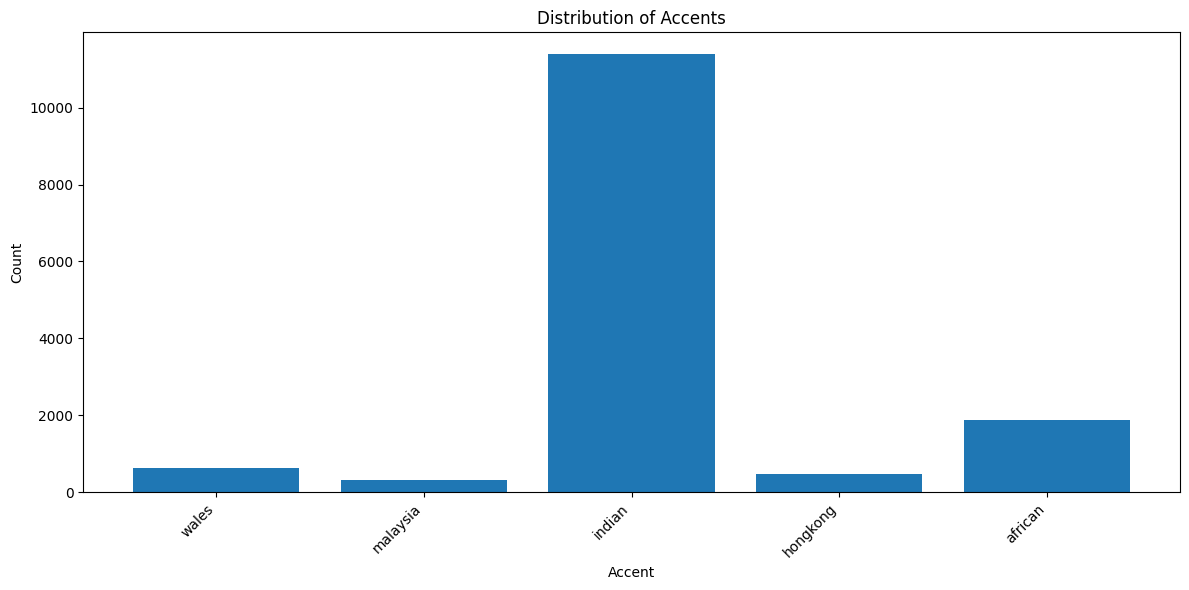

shape: (6, 2)
┌──────────┬───────┐
│ age      ┆ count │
│ ---      ┆ ---   │
│ str      ┆ u32   │
╞══════════╪═══════╡
│ twenties ┆ 6719  │
│ sixties  ┆ 610   │
│ teens    ┆ 944   │
│ thirties ┆ 1994  │
│ fifties  ┆ 3985  │
│ fourties ┆ 414   │
└──────────┴───────┘


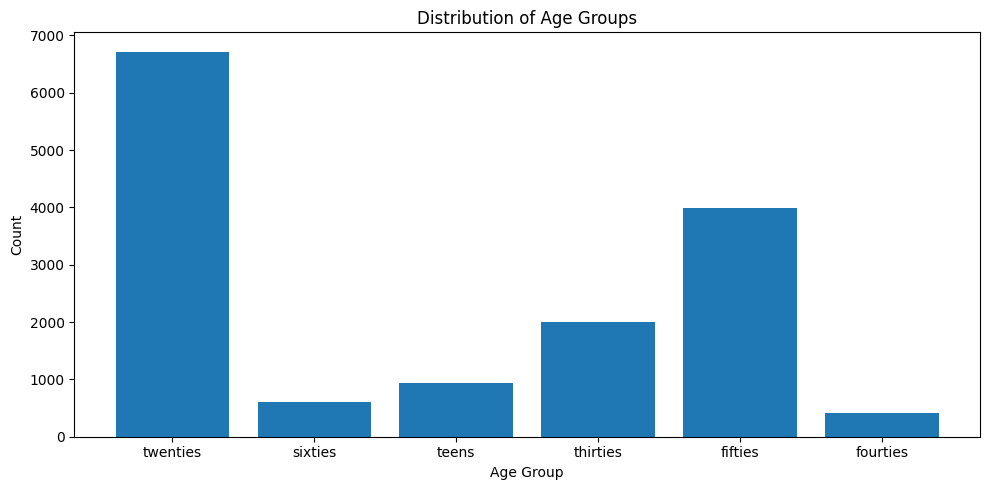

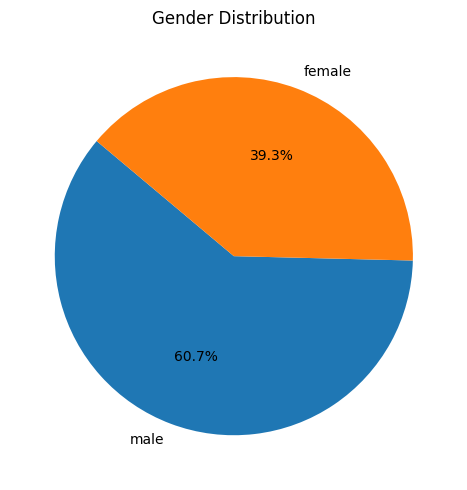

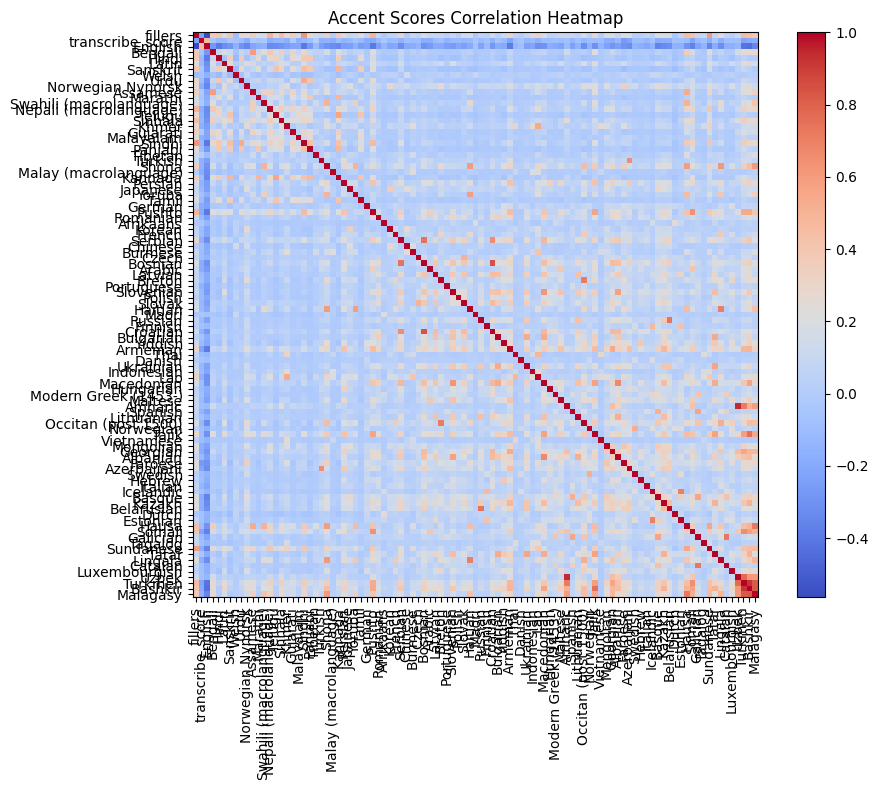

Fillers Analysis:
shape: (9, 2)
┌────────────┬──────────┐
│ statistic  ┆ fillers  │
│ ---        ┆ ---      │
│ str        ┆ f64      │
╞════════════╪══════════╡
│ count      ┆ 14681.0  │
│ null_count ┆ 0.0      │
│ mean       ┆ 0.00072  │
│ std        ┆ 0.00079  │
│ min        ┆ 0.000002 │
│ 25%        ┆ 0.000183 │
│ 50%        ┆ 0.000466 │
│ 75%        ┆ 0.000967 │
│ max        ┆ 0.013053 │
└────────────┴──────────┘


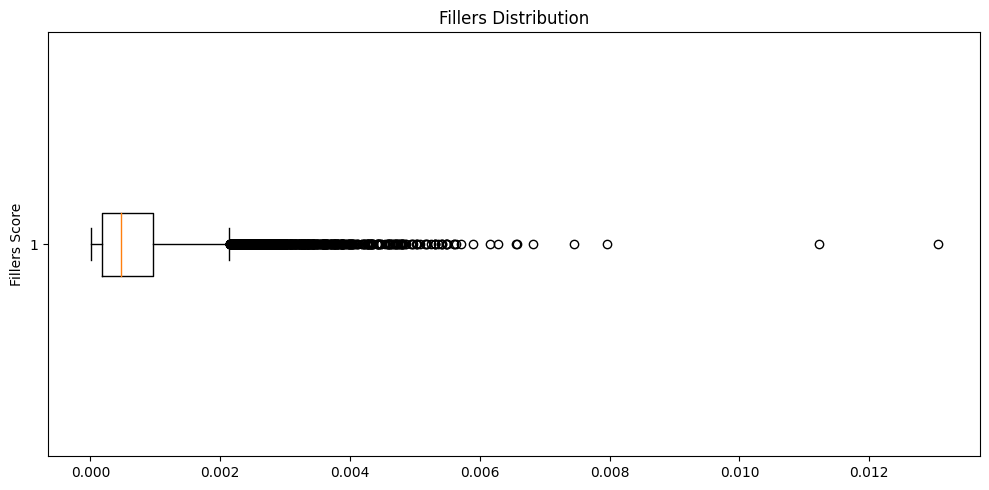

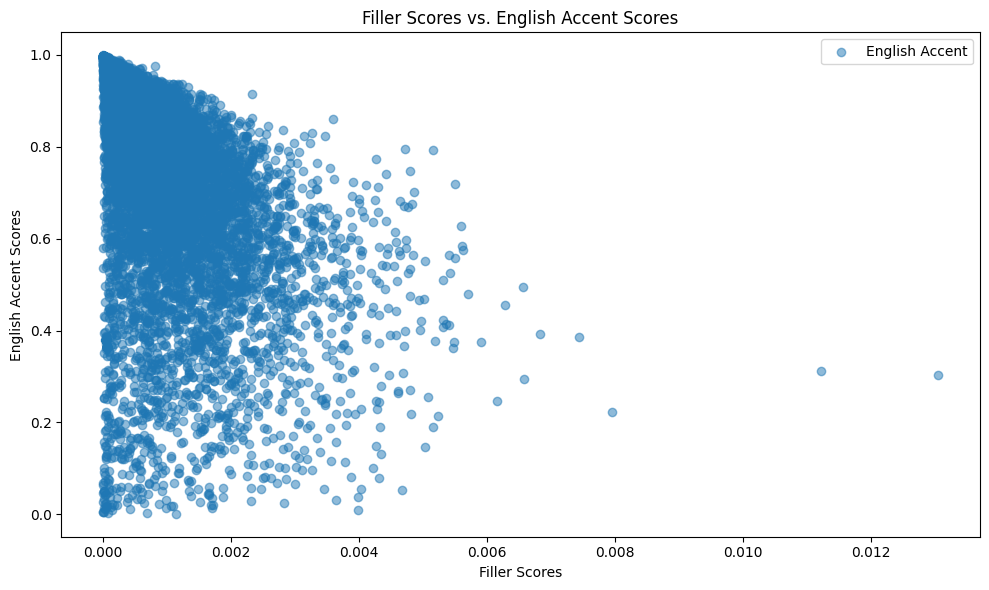

Transcribe Score Analysis:
shape: (9, 2)
┌────────────┬──────────────────┐
│ statistic  ┆ transcribe_score │
│ ---        ┆ ---              │
│ str        ┆ f64              │
╞════════════╪══════════════════╡
│ count      ┆ 14681.0          │
│ null_count ┆ 0.0              │
│ mean       ┆ 28.395903        │
│ std        ┆ 6.651186         │
│ min        ┆ -3.035287        │
│ 25%        ┆ 24.177804        │
│ 50%        ┆ 28.693684        │
│ 75%        ┆ 32.932796        │
│ max        ┆ 48.693205        │
└────────────┴──────────────────┘


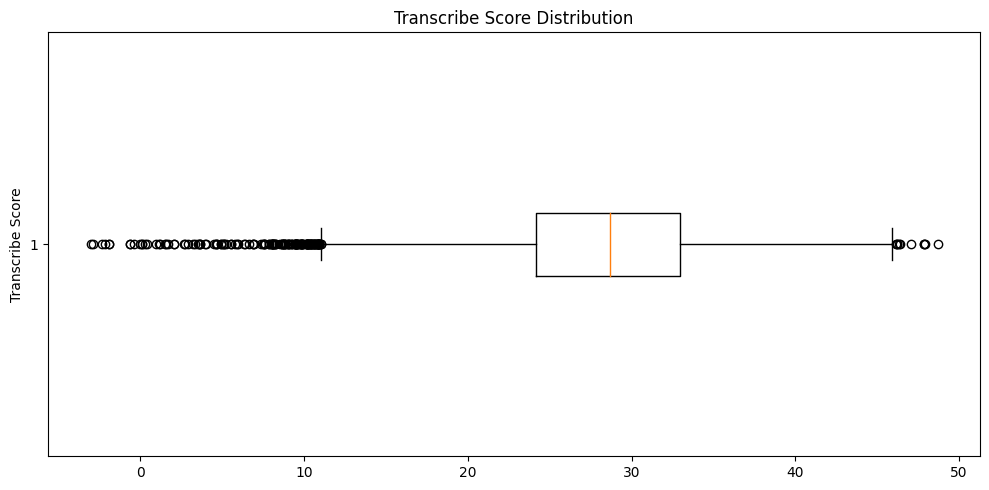

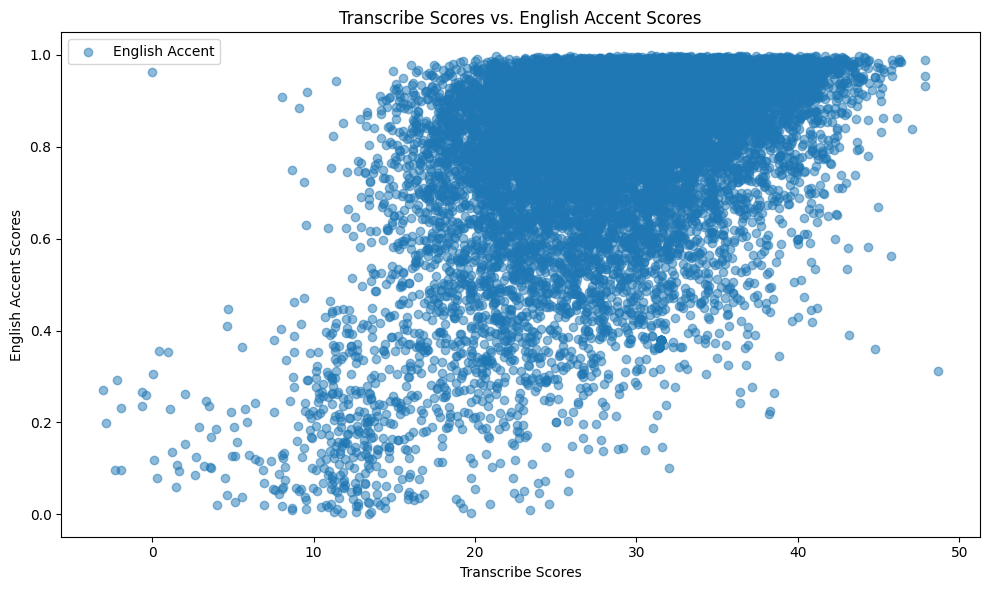

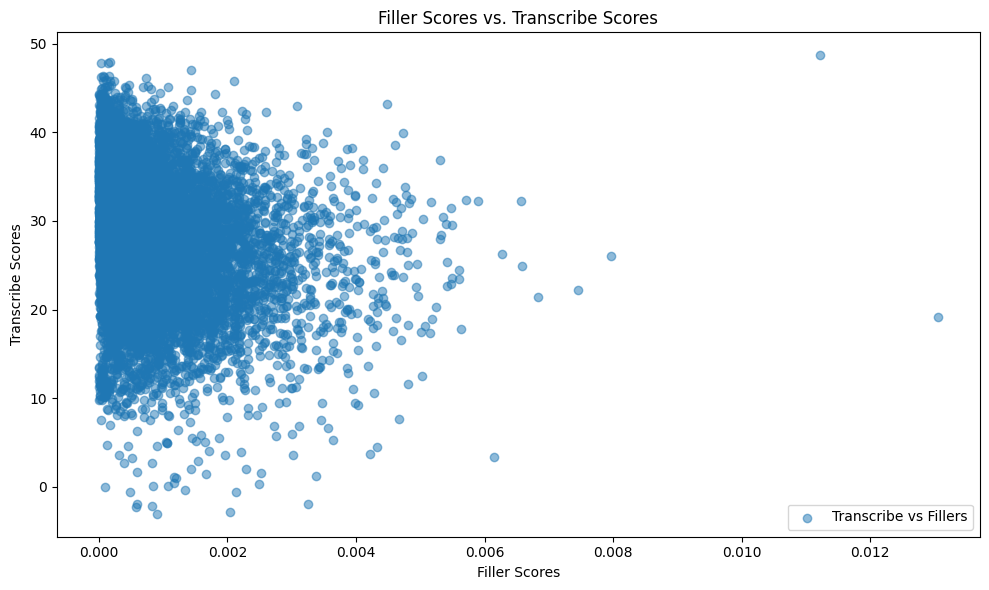

In [9]:
import polars as pl
import matplotlib.pyplot as plt

def perform_basic_eda(df):
    # 1. General Information
    print("Dataset Overview:")
    print(df.describe())

    # 2. Plot the distribution of accents
    accents_count = (
        df.group_by("accent")
        .agg(pl.col("accent").count().alias("count"))
        .filter(pl.col("accent").is_not_null())
    )
    plt.figure(figsize=(12, 6))
    plt.bar(accents_count["accent"].to_list(), accents_count["count"].to_list())
    plt.xticks(rotation=45, ha="right")
    plt.title("Distribution of Accents")
    plt.ylabel("Count")
    plt.xlabel("Accent")
    plt.tight_layout()
    plt.show()

    # 3. Distribution of Age Groups
    age_count = (
        df.filter(pl.col("age").is_not_null())
        .group_by("age")
        .agg(pl.col("age").count().alias("count"))
    )

    print(age_count)

    plt.figure(figsize=(10, 5))
    plt.bar(age_count["age"].to_list(), age_count["count"].to_list())
    plt.title("Distribution of Age Groups")
    plt.ylabel("Count")
    plt.xlabel("Age Group")
    plt.tight_layout()
    plt.show()

    # 4. Gender Distribution
    gender_count = (
        df.filter(pl.col("gender").is_not_null())
        .group_by("gender")
        .agg(pl.col("gender").count().alias("count"))
    )

    plt.figure(figsize=(8, 5))
    plt.pie(
        gender_count["count"].to_list(), 
        labels=gender_count["gender"].to_list(), 
        autopct="%1.1f%%", 
        startangle=140
    )
    plt.title("Gender Distribution")
    plt.tight_layout()
    plt.show()

    # 5. Accent Scores Heatmap for Sample Data
    numeric_columns = df.select(pl.col(pl.Float64))
    numeric_data = numeric_columns.to_numpy()
    column_names = numeric_columns.columns

    plt.figure(figsize=(10, 8))
    plt.imshow(pl.DataFrame(numeric_columns.corr()).to_numpy(), cmap="coolwarm", interpolation="none")
    plt.colorbar()
    plt.title("Accent Scores Correlation Heatmap")
    plt.xticks(range(len(column_names)), column_names, rotation=90)
    plt.yticks(range(len(column_names)), column_names)
    plt.tight_layout()
    plt.show()

    # 6. Fillers Analysis
    fillers_summary = df.filter(pl.col("fillers").is_not_null()).select("fillers")
    print("Fillers Analysis:")
    print(fillers_summary.describe())

    plt.figure(figsize=(10, 5))
    plt.boxplot(fillers_summary["fillers"].to_list(), vert=False)
    plt.title("Fillers Distribution")
    plt.ylabel("Fillers Score")
    plt.tight_layout()
    plt.show()

    # 7. Scatter Plot of Filler Scores vs. English Scores
    scatter_data_fillers_english = df.filter(
        pl.col("fillers").is_not_null() & pl.col("English").is_not_null()
    )

    plt.figure(figsize=(10, 6))
    plt.scatter(
        scatter_data_fillers_english["fillers"].to_list(), 
        scatter_data_fillers_english["English"].to_list(), 
        alpha=0.5, 
        label="English Accent"
    )
    plt.title("Filler Scores vs. English Accent Scores")
    plt.xlabel("Filler Scores")
    plt.ylabel("English Accent Scores")
    plt.legend()
    plt.tight_layout()
    plt.show()

    # 8. Transcribe Score Analysis
    transcribe_summary = df.filter(pl.col("transcribe_score").is_not_null()).select("transcribe_score")
    print("Transcribe Score Analysis:")
    print(transcribe_summary.describe())

    plt.figure(figsize=(10, 5))
    plt.boxplot(transcribe_summary["transcribe_score"].to_list(), vert=False)
    plt.title("Transcribe Score Distribution")
    plt.ylabel("Transcribe Score")
    plt.tight_layout()
    plt.show()

    # 9. Scatter Plot of Transcribe Scores vs. English Scores
    scatter_data_transcribe_english = df.filter(
        pl.col("transcribe_score").is_not_null() & pl.col("English").is_not_null()
    )

    plt.figure(figsize=(10, 6))
    plt.scatter(
        scatter_data_transcribe_english["transcribe_score"].to_list(), 
        scatter_data_transcribe_english["English"].to_list(), 
        alpha=0.5, 
        label="English Accent"
    )
    plt.title("Transcribe Scores vs. English Accent Scores")
    plt.xlabel("Transcribe Scores")
    plt.ylabel("English Accent Scores")
    plt.legend()
    plt.tight_layout()
    plt.show()

    # 10. Scatter Plot of Filler Scores vs. Transcribe Scores
    scatter_data_fillers_transcribe = df.filter(
        pl.col("fillers").is_not_null() & pl.col("transcribe_score").is_not_null()
    )

    plt.figure(figsize=(10, 6))
    plt.scatter(
        scatter_data_fillers_transcribe["fillers"].to_list(), 
        scatter_data_fillers_transcribe["transcribe_score"].to_list(), 
        alpha=0.5, 
        label="Transcribe vs Fillers"
    )
    plt.title("Filler Scores vs. Transcribe Scores")
    plt.xlabel("Filler Scores")
    plt.ylabel("Transcribe Scores")
    plt.legend()
    plt.tight_layout()
    plt.show()

perform_basic_eda(df)


# Accents EDA

/tmp/ipykernel_23/678062679.py:7: DeprecationWarning: `pl.count()` is deprecated. Please use `pl.len()` instead.
  accent_count = df.group_by("accent").agg(pl.count().alias("total"))


Accent Distribution:
shape: (5, 2)
┌──────────┬───────┐
│ accent   ┆ total │
│ ---      ┆ ---   │
│ str      ┆ u32   │
╞══════════╪═══════╡
│ hongkong ┆ 463   │
│ african  ┆ 1877  │
│ malaysia ┆ 332   │
│ indian   ┆ 11387 │
│ wales    ┆ 622   │
└──────────┴───────┘


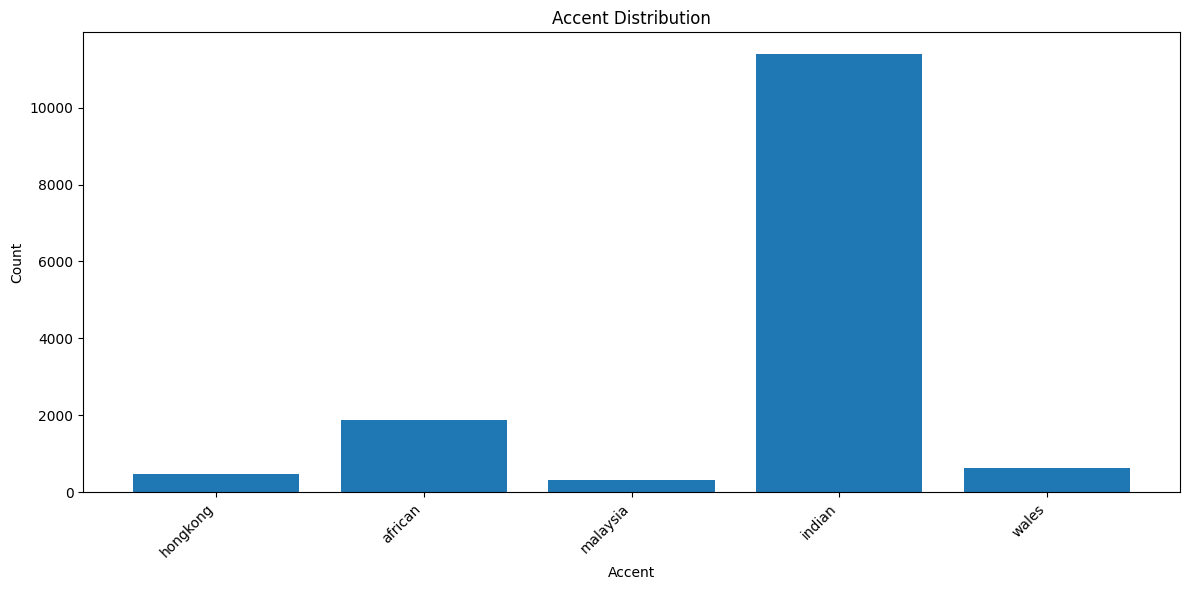

Mean Scores for Each Accent:
shape: (5, 98)
┌──────────┬───────────┬───────────┬───────────┬───┬───────────┬───────────┬───────────┬───────────┐
│ accent   ┆ mean_Engl ┆ mean_Beng ┆ mean_Hind ┆ … ┆ mean_Uzbe ┆ mean_Turk ┆ mean_Bash ┆ mean_Mala │
│ ---      ┆ ish       ┆ ali       ┆ i         ┆   ┆ k         ┆ men       ┆ kir       ┆ gasy      │
│ str      ┆ ---       ┆ ---       ┆ ---       ┆   ┆ ---       ┆ ---       ┆ ---       ┆ ---       │
│          ┆ f64       ┆ f64       ┆ f64       ┆   ┆ f64       ┆ f64       ┆ f64       ┆ f64       │
╞══════════╪═══════════╪═══════════╪═══════════╪═══╪═══════════╪═══════════╪═══════════╪═══════════╡
│ hongkong ┆ 0.788247  ┆ 0.000644  ┆ 0.001475  ┆ … ┆ 1.9590e-7 ┆ 1.1564e-7 ┆ 1.8585e-7 ┆ 1.3628e-7 │
│ wales    ┆ 0.882038  ┆ 0.000137  ┆ 0.000661  ┆ … ┆ 4.6074e-8 ┆ 2.6019e-8 ┆ 4.7612e-8 ┆ 2.3435e-8 │
│ malaysia ┆ 0.600831  ┆ 0.001296  ┆ 0.003217  ┆ … ┆ 2.2177e-7 ┆ 9.8464e-8 ┆ 1.5676e-7 ┆ 1.0636e-7 │
│ indian   ┆ 0.788441  ┆ 0.009718  ┆ 0.039233  

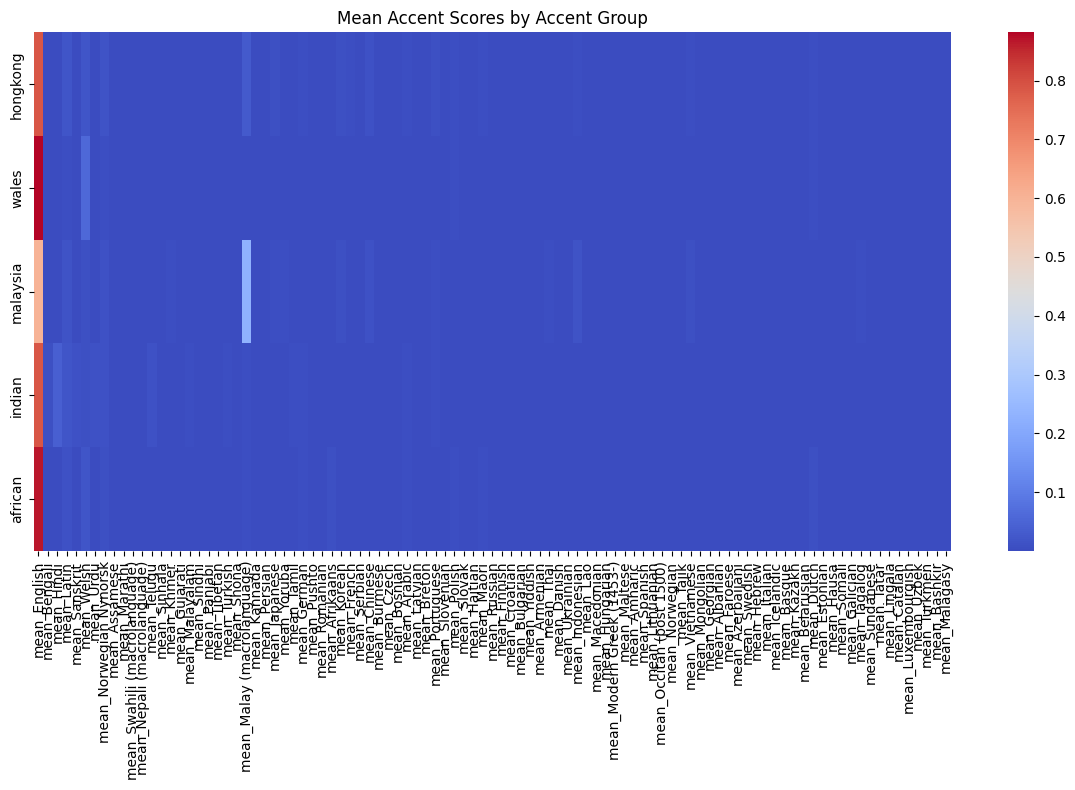

Variance of Scores for Each Accent:
shape: (5, 98)
┌──────────┬───────────┬───────────┬───────────┬───┬───────────┬───────────┬───────────┬───────────┐
│ accent   ┆ var_Engli ┆ var_Benga ┆ var_Hindi ┆ … ┆ var_Uzbek ┆ var_Turkm ┆ var_Bashk ┆ var_Malag │
│ ---      ┆ sh        ┆ li        ┆ ---       ┆   ┆ ---       ┆ en        ┆ ir        ┆ asy       │
│ str      ┆ ---       ┆ ---       ┆ f64       ┆   ┆ f64       ┆ ---       ┆ ---       ┆ ---       │
│          ┆ f64       ┆ f64       ┆           ┆   ┆           ┆ f64       ┆ f64       ┆ f64       │
╞══════════╪═══════════╪═══════════╪═══════════╪═══╪═══════════╪═══════════╪═══════════╪═══════════╡
│ malaysia ┆ 0.085628  ┆ 0.000009  ┆ 0.000265  ┆ … ┆ 2.2759e-1 ┆ 2.7646e-1 ┆ 7.1064e-1 ┆ 3.2712e-1 │
│          ┆           ┆           ┆           ┆   ┆ 3         ┆ 4         ┆ 4         ┆ 4         │
│ indian   ┆ 0.0358    ┆ 0.000782  ┆ 0.004209  ┆ … ┆ 8.5862e-1 ┆ 9.6406e-1 ┆ 1.0442e-1 ┆ 9.9108e-1 │
│          ┆           ┆           ┆    

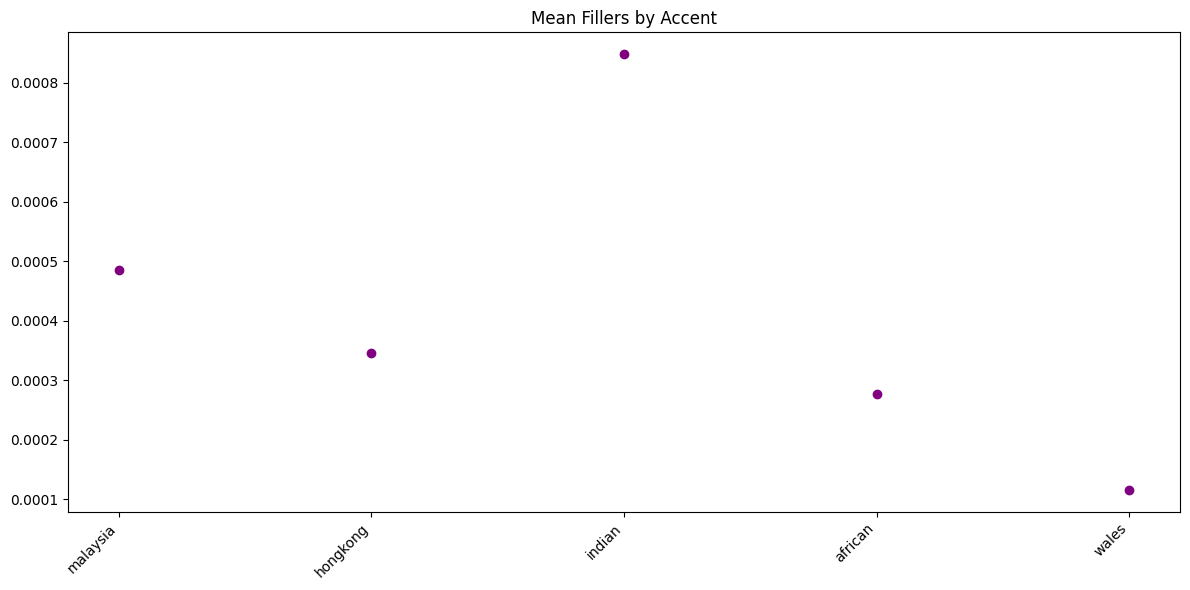

Mean Scores by Accent:
shape: (5, 2)
┌──────────┬───────────────────────┐
│ accent   ┆ mean_transcribe_score │
│ ---      ┆ ---                   │
│ str      ┆ f64                   │
╞══════════╪═══════════════════════╡
│ hongkong ┆ 29.408243             │
│ malaysia ┆ 24.816052             │
│ wales    ┆ 31.265696             │
│ african  ┆ 30.843951             │
│ indian   ┆ 27.898827             │
└──────────┴───────────────────────┘


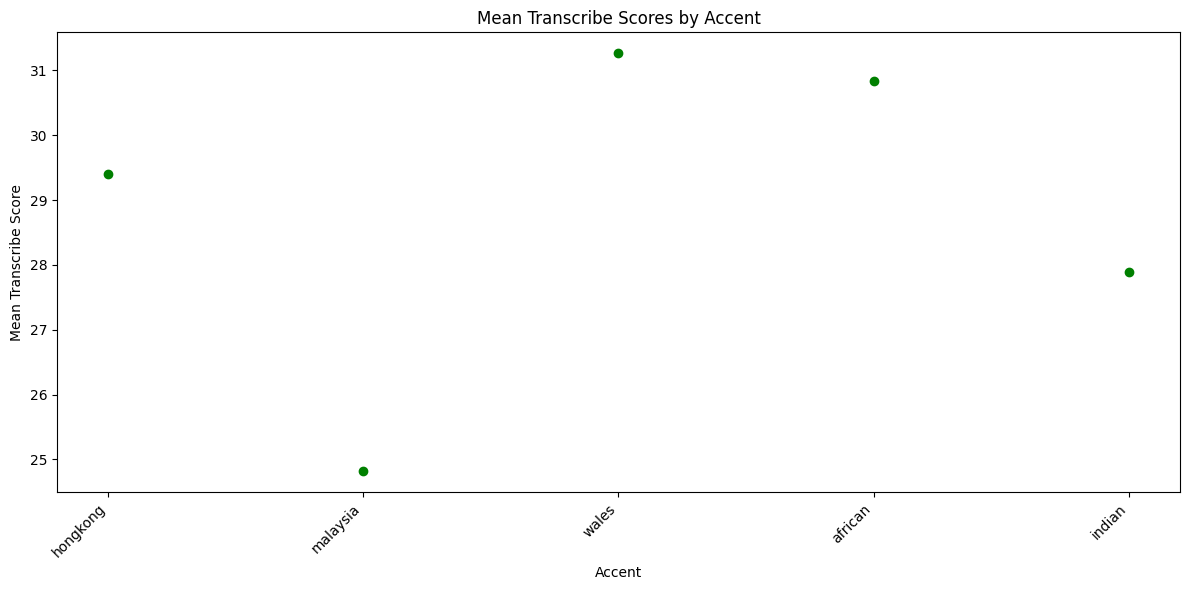

Accent Coverage by Age:
shape: (27, 3)
┌──────────┬──────────┬───────┐
│ accent   ┆ age      ┆ count │
│ ---      ┆ ---      ┆ ---   │
│ str      ┆ str      ┆ u32   │
╞══════════╪══════════╪═══════╡
│ indian   ┆ thirties ┆ 1209  │
│ hongkong ┆ fourties ┆ 88    │
│ african  ┆ twenties ┆ 552   │
│ wales    ┆ thirties ┆ 79    │
│ indian   ┆ teens    ┆ 528   │
│ …        ┆ …        ┆ …     │
│ malaysia ┆ fifties  ┆ 17    │
│ malaysia ┆ sixties  ┆ 15    │
│ wales    ┆ teens    ┆ 28    │
│ african  ┆ teens    ┆ 247   │
│ hongkong ┆ twenties ┆ 121   │
└──────────┴──────────┴───────┘


/tmp/ipykernel_23/678062679.py:80: DeprecationWarning: `GroupBy.count` is deprecated. It has been renamed to `len`.
  accent_age_coverage = df.group_by(["accent", "age"]).count()


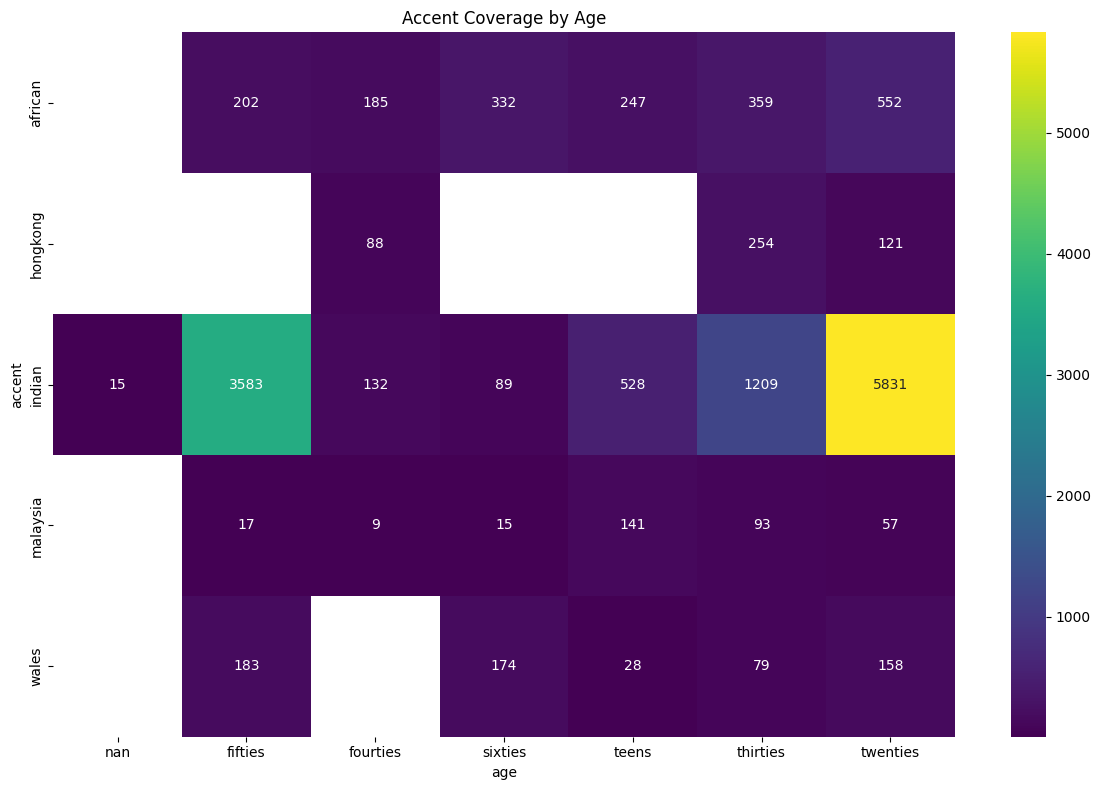

/tmp/ipykernel_23/678062679.py:96: DeprecationWarning: `DataFrame.melt` is deprecated. Use `unpivot` instead, with `index` instead of `id_vars` and `on` instead of `value_vars`
  top_5_scores = accent_mean_scores.melt().sort("value", descending=True)[:5]


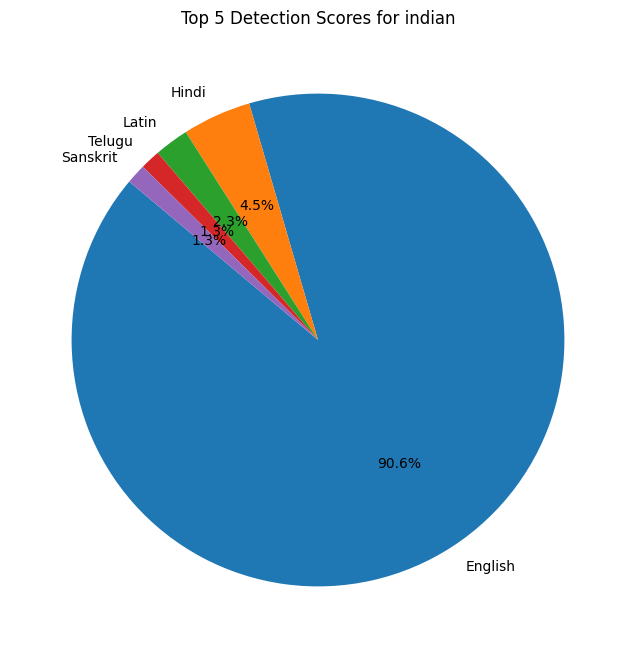

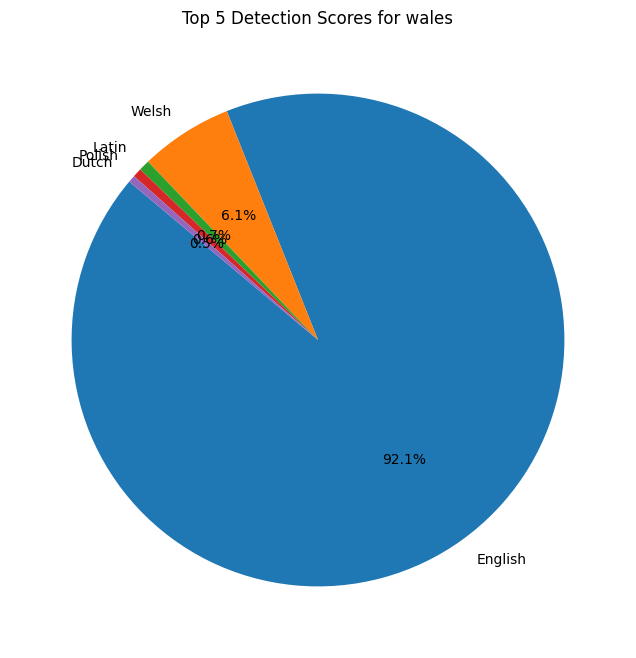

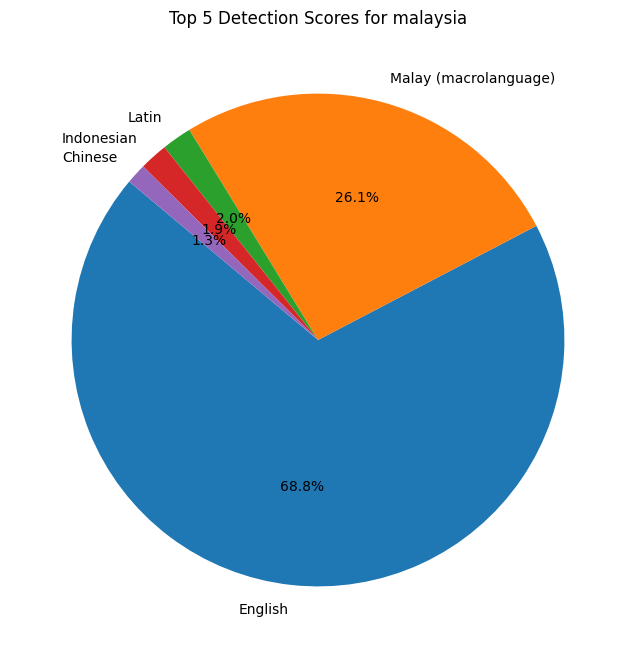

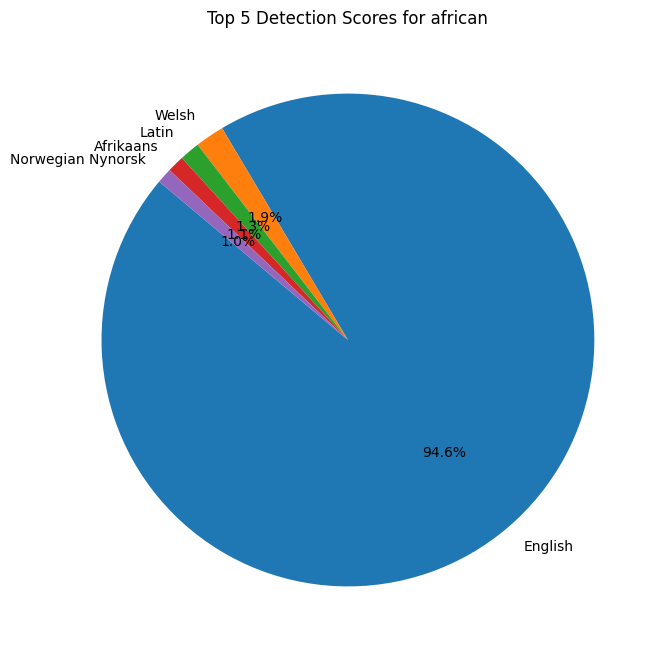

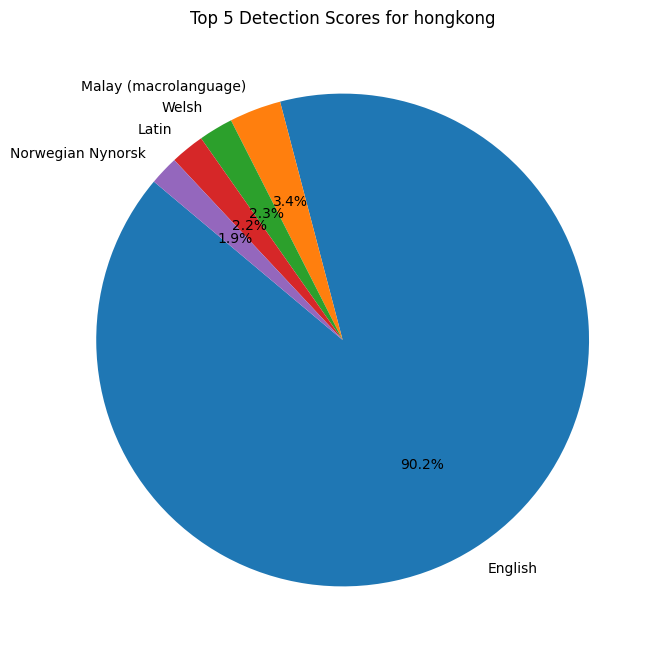

In [10]:
import polars as pl
import matplotlib.pyplot as plt
import seaborn as sns

def accent_eda(df):
    # Accent Distribution
    accent_count = df.group_by("accent").agg(pl.count().alias("total"))
    print("Accent Distribution:")
    print(accent_count)
    plt.figure(figsize=(12, 6))
    plt.bar(accent_count["accent"].to_list(), accent_count["total"].to_list())
    plt.xticks(rotation=45, ha="right")
    plt.title("Accent Distribution")
    plt.ylabel("Count")
    plt.xlabel("Accent")
    plt.tight_layout()
    plt.show()

    # Mean Scores for Each Accent
    accent_means = df.group_by("accent").agg([pl.col(col).mean().alias(f"mean_{col}") for col in accent_cols])
    output_csv = "/kaggle/working/accent_means.csv"
    accent_means.write_csv(output_csv)
    print("Mean Scores for Each Accent:")
    print(accent_means)

    # Heatmap of Mean Scores
    numerical_cols = [col for col in accent_means.columns if col != "accent"]
    accent_means_matrix = accent_means.select(numerical_cols).to_numpy()
    plt.figure(figsize=(12, 8))
    sns.heatmap(
        accent_means_matrix.astype(float),  # Ensure conversion to float
        cmap="coolwarm", annot=False,
        xticklabels=numerical_cols, yticklabels=accent_means["accent"].to_list(), cbar=True
    )
    plt.title("Mean Accent Scores by Accent Group")
    plt.tight_layout()
    plt.show()

    # Variance of Scores for Each Accent
    accent_variances = df.group_by("accent").agg([pl.col(col).var().alias(f"var_{col}") for col in accent_cols])
    print("Variance of Scores for Each Accent:")
    print(accent_variances)

    # Top-N Accents Based on English Score
    top_n_accents = df.group_by("accent").agg(
        pl.col("English").mean().alias("mean_english_score")
    ).sort("mean_english_score", descending=True)
    print("Top Accents by English Score:")
    print(top_n_accents)

    # Scatter Plot of Mean Fillers by Accent
    accent_fillers = df.group_by("accent").agg(
        pl.col("fillers").mean().alias("mean_fillers")
    )
    print("Mean Fillers by Accent:")
    print(accent_fillers)
    plt.figure(figsize=(12, 6))
    plt.scatter(accent_fillers["accent"].to_list(), accent_fillers["mean_fillers"].to_list(), color="purple")
    plt.xticks(rotation=45, ha="right")
    plt.title("Mean Fillers by Accent")
    plt.tight_layout()
    plt.show()

    # Scatter Plot of Mean Scores by Accent
    accent_mean_scores = df.group_by("accent").agg(
        pl.col("transcribe_score").mean().alias("mean_transcribe_score")
    )
    print("Mean Scores by Accent:")
    print(accent_mean_scores)
    plt.figure(figsize=(12, 6))
    plt.scatter(accent_mean_scores["accent"].to_list(), accent_mean_scores["mean_transcribe_score"].to_list(), color="green")
    plt.xticks(rotation=45, ha="right")
    plt.title("Mean Transcribe Scores by Accent")
    plt.ylabel("Mean Transcribe Score")
    plt.xlabel("Accent")
    plt.tight_layout()
    plt.show()

    # Accent Coverage by Age
    accent_age_coverage = df.group_by(["accent", "age"]).count()
    print("Accent Coverage by Age:")
    print(accent_age_coverage)
    plt.figure(figsize=(12, 8))
    pivot_table = accent_age_coverage.to_pandas().pivot(index="accent", columns="age", values="count")
    sns.heatmap(
        pivot_table, cmap="viridis", annot=True, fmt=".0f"
    )
    plt.title("Accent Coverage by Age")
    plt.tight_layout()
    plt.show()

    # Top 5 Detection Scores for Each Accent (Pie Chart)
    for accent in df.select("accent").unique()["accent"].to_list():
        accent_data = df.filter(pl.col("accent") == accent)
        accent_mean_scores = accent_data.select(accent_cols).mean()
        top_5_scores = accent_mean_scores.melt().sort("value", descending=True)[:5]
        plt.figure(figsize=(8, 8))
        plt.pie(top_5_scores["value"], labels=top_5_scores["variable"], autopct="%1.1f%%", startangle=140)
        plt.title(f"Top 5 Detection Scores for {accent}")
        plt.show()


accent_eda(df)

# Accent Evaluation Accuracy Analysis

/tmp/ipykernel_23/457923114.py:10: MapWithoutReturnDtypeWarning: Calling `map_elements` without specifying `return_dtype` can lead to unpredictable results. Specify `return_dtype` to silence this warning.
  df = df.with_columns(
/tmp/ipykernel_23/457923114.py:10: MapWithoutReturnDtypeWarning: Calling `map_elements` without specifying `return_dtype` can lead to unpredictable results. Specify `return_dtype` to silence this warning.
  df = df.with_columns(
/tmp/ipykernel_23/457923114.py:10: MapWithoutReturnDtypeWarning: Calling `map_elements` without specifying `return_dtype` can lead to unpredictable results. Specify `return_dtype` to silence this warning.
  df = df.with_columns(
/tmp/ipykernel_23/457923114.py:10: MapWithoutReturnDtypeWarning: Calling `map_elements` without specifying `return_dtype` can lead to unpredictable results. Specify `return_dtype` to silence this warning.
  df = df.with_columns(
/tmp/ipykernel_23/457923114.py:10: MapWithoutReturnDtypeWarning: Calling `map_elemen

shape: (5, 8)
┌────────────┬────────────┬────────────┬───────────┬───────────┬───────────┬───────────┬───────────┐
│ lang       ┆ sample_cou ┆ mean_engli ┆ mean_top_ ┆ mean_top_ ┆ mean_top_ ┆ mean_top_ ┆ mean_top_ │
│ ---        ┆ nt         ┆ sh_score   ┆ 1_match   ┆ 2_match   ┆ 3_match   ┆ 4_match   ┆ 5_match   │
│ str        ┆ ---        ┆ ---        ┆ ---       ┆ ---       ┆ ---       ┆ ---       ┆ ---       │
│            ┆ u32        ┆ f64        ┆ f32       ┆ f32       ┆ f32       ┆ f32       ┆ f32       │
╞════════════╪════════════╪════════════╪═══════════╪═══════════╪═══════════╪═══════════╪═══════════╡
│ Afrikaans  ┆ 1877       ┆ 0.867188   ┆ 0.004262  ┆ 0.047416  ┆ 0.048482  ┆ 0.053277  ┆ 0.051145  │
│ Malay (mac ┆ 332        ┆ 0.600831   ┆ 0.253012  ┆ 0.246988  ┆ 0.090361  ┆ 0.042169  ┆ 0.051205  │
│ rolanguage ┆            ┆            ┆           ┆           ┆           ┆           ┆           │
│ )          ┆            ┆            ┆           ┆           ┆           ┆ 

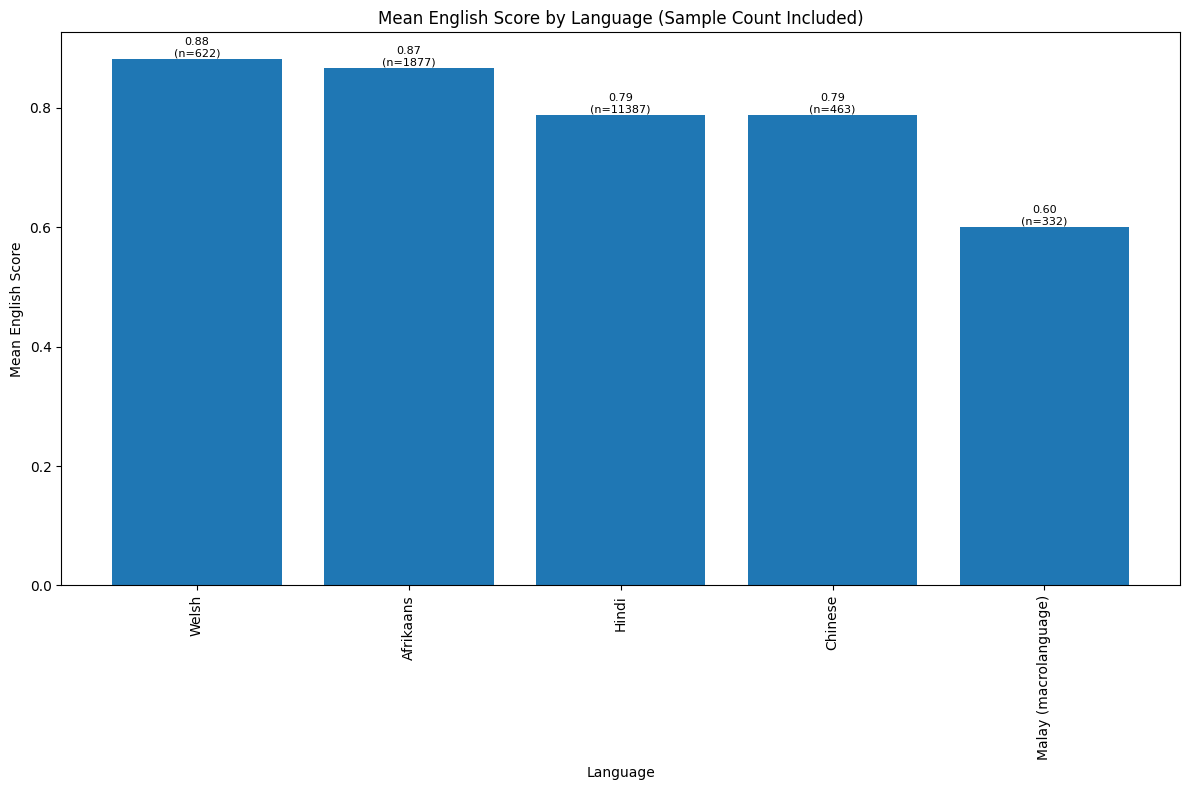

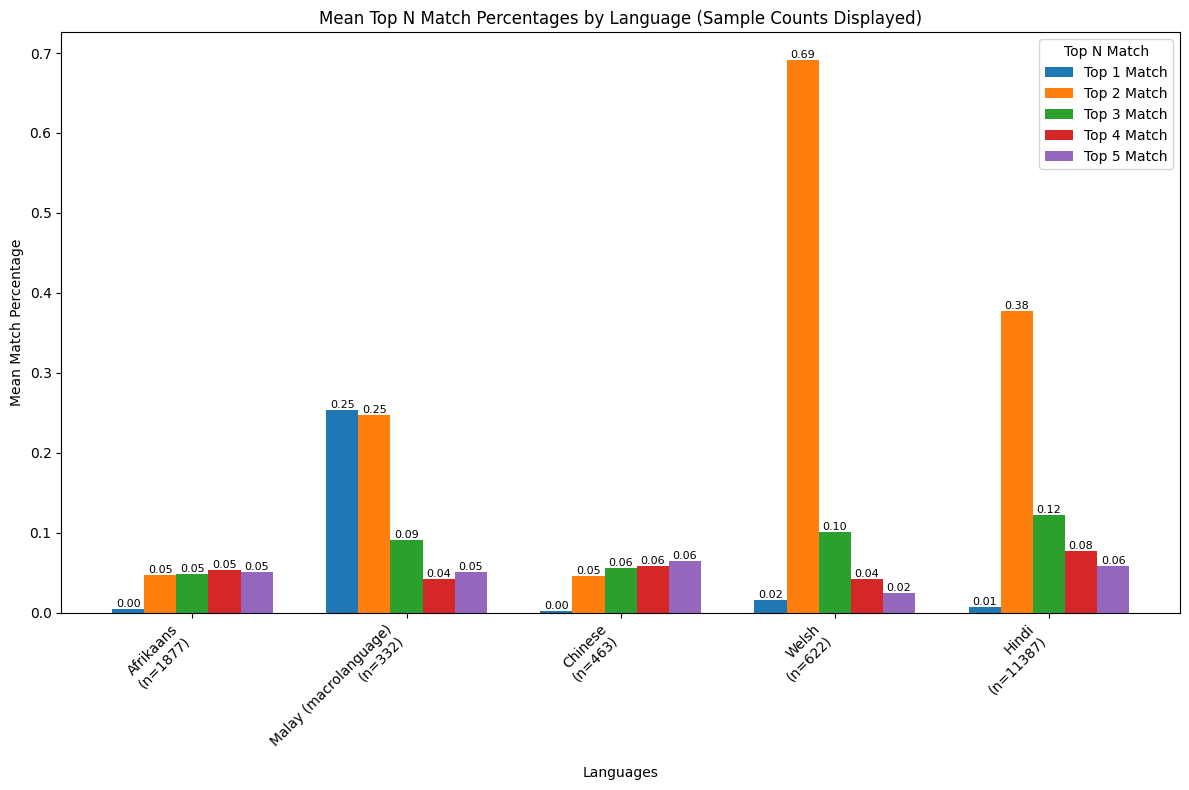

In [11]:
import polars as pl
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

def top_n_languages_extraction(df, accent_cols, n=5):
    # Ensure all accent columns are sorted by their scores
    for i in range(n):
        # Create a column for each top N rank
        df = df.with_columns(
            pl.struct(accent_cols)
            .map_elements(lambda x: sorted(zip(accent_cols, x.values()), key=lambda y: -y[1])[i][0] if i < len(accent_cols) else None)
            .alias(f"top_{i+1}_lang")
        )
    return df
    
def analyze_lang_accuracy(df):
    # Add columns for top 1 to 5 ranked languages
    df = top_n_languages_extraction(df, accent_cols, n=5)

    # Calculate the percentage of lang that matches the second-ranked language
    match_columns = [
        (pl.col("lang") == pl.col(f"top_{n}_lang")).cast(pl.Float32).alias(f"top_{n}_match")
        for n in range(1, 6)
    ]
    df = df.with_columns(match_columns)

    # Group by 'lang' and calculate mean English score, mean lang_match, and sample count
    grouped_df = df.group_by("lang").agg(
        [
            pl.col("lang").count().alias("sample_count"),
            pl.col("English").mean().alias("mean_english_score"),
        ] + [
            pl.col(f"top_{n}_match").mean().alias(f"mean_top_{n}_match") for n in range(1, 6)
        ]
    )
    print(grouped_df.select(pl.exclude(accent_cols)))
    print(grouped_df.select(pl.exclude(accent_cols)).describe())


    # Visualization 1: Mean English Score by Language
    grouped_df_sorted = grouped_df.sort("mean_english_score", descending=True)

    plt.figure(figsize=(12, 8))
    plt.bar(
        grouped_df_sorted["lang"].to_list(),
        grouped_df_sorted["mean_english_score"].to_list(),
    )
    plt.xticks(rotation=90)
    plt.xlabel("Language")
    plt.ylabel("Mean English Score")
    plt.title("Mean English Score by Language (Sample Count Included)")

    # Add value labels to the bars
    for idx, (lang, score, count) in enumerate(
        zip(grouped_df_sorted["lang"], grouped_df_sorted["mean_english_score"], grouped_df_sorted["sample_count"])
    ):
        plt.text(
            idx,
            score,
            f'{score:.2f}\n(n={count})',
            ha='center',
            va='bottom',
            fontsize=8,
        )
    plt.tight_layout()
    plt.show()

    # Visualization 2: Mean Top N Match Percentages by Language
    langs = grouped_df["lang"].to_list()
    sample_counts = grouped_df["sample_count"].to_list()
    mean_columns = [f"mean_top_{n}_match" for n in range(1, 6)]
    means = grouped_df.select(mean_columns).to_numpy()

    # Set bar width and positions
    bar_width = 0.15
    x_positions = np.arange(len(langs))

    fig, ax = plt.subplots(figsize=(12, 8))

    for i, mean_col in enumerate(mean_columns):
        bars = ax.bar(
            x_positions + i * bar_width,
            means[:, i],
            bar_width,
            label=mean_col.replace("mean_", "").replace("_", " ").title(),
        )

        # Add value annotations to each bar
        for bar in bars:
            ax.text(
                bar.get_x() + bar.get_width() / 2,
                bar.get_height(),
                f"{bar.get_height():.2f}",
                ha="center",
                va="bottom",
                fontsize=8,
            )

    # Add labels, legend, and title
    ax.set_xticks(x_positions + bar_width * 2)
    xtick_labels = [f"{lang}\n(n={count})" for lang, count in zip(langs, sample_counts)]
    ax.set_xticklabels(xtick_labels, rotation=45, ha="right")
    ax.set_ylabel("Mean Match Percentage")
    ax.set_xlabel("Languages")
    ax.set_title("Mean Top N Match Percentages by Language (Sample Counts Displayed)")
    ax.legend(title="Top N Match", loc="upper right")
    plt.tight_layout()
    plt.show()

    return grouped_df

# Usage
grouped_df = analyze_lang_accuracy(df)


# Play Audios

In [12]:
import base64
from IPython.display import display, HTML, Audio
import polars as pl

# Function to play audio files
def play_audio(audio_file_path):
    """Play an audio file using IPython's Audio display."""
    audio = Audio(filename=f"/kaggle/input/common-voice/{audio_file_path.split('/')[0]}/" + audio_file_path)
    # display(audio)
    return audio

# Function to display descriptive statistics and audio playback in a table
def analyze_and_play_audios_with_table(df, column, filename_col="filename"):
    """Analyze a specific column, display statistics in a table, and play audio files."""
    describe_df = df[column].describe()
    metrics = ["mean", "min", "25%", "50%", "75%", "max"]
    
    # Build HTML table header
    html_table = f"<h3>Descriptive statistics for '{column}'</h3>"
    html_table += "<table border='1' style='border-collapse: collapse; width: 100%;'>"
    html_table += "<tr><th>Metric</th><th>Value</th><th style='width: 50%;'>Audio</th></tr>"

    # Add rows for each metric
    for metric in metrics:
        metric_value = describe_df.filter(pl.col("statistic") == metric).select("value").item()
        closest_row = df.with_columns((pl.col(column) - metric_value).abs().alias("diff"))
        closest_file = closest_row.sort("diff").select(filename_col)[0].item()
        file_path = f"/kaggle/input/common-voice/{closest_file.split('/')[0]}/" + closest_file
        
        # Load the audio file and encode it in base64
        with open(file_path, "rb") as audio_file:
            audio_data = audio_file.read()
        audio_base64 = base64.b64encode(audio_data).decode('utf-8')
        audio_src = f"data:audio/mpeg;base64,{audio_base64}"
        
        # Add HTML row for the metric
        html_table += (
            f"<tr>"
            f"<td>{metric.capitalize()}</td>"
            f"<td>{metric_value:.2f}</td>"
            f"<td><audio controls><source src='{audio_src}' type='audio/mpeg'></audio></td>"
            f"</tr>"
        )
        
    # Close the HTML table
    html_table += "</table>"
    
    # Display the table
    display(HTML(html_table))

## Top 1~5 Langs

In [13]:
accent_mean_scores = df.select(accent_cols).mean()
top_5_scores = accent_mean_scores.melt().sort("value", descending=True)[:5]
for lang in top_5_scores["variable"].to_list():
    analyze_and_play_audios_with_table(df, lang)

/tmp/ipykernel_23/3285321184.py:2: DeprecationWarning: `DataFrame.melt` is deprecated. Use `unpivot` instead, with `index` instead of `id_vars` and `on` instead of `value_vars`
  top_5_scores = accent_mean_scores.melt().sort("value", descending=True)[:5]


## Fillers

In [14]:
analyze_and_play_audios_with_table(df, "fillers")

## Transcribe Score

In [15]:
analyze_and_play_audios_with_table(df, "transcribe_score")